In [84]:
# Cell 1 — setup & paths
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, sys, os

# locate project root (walk up until 'data' folder found)
root = Path.cwd()
for _ in range(6):
    if (root / "data").exists():
        break
    root = root.parent
ROOT = root
RAW = ROOT / "data" / "raw"
PROC = ROOT / "data" / "processed"
OUT = ROOT / "outputs" / "figures"
PROC.mkdir(parents=True, exist_ok=True)
OUT.mkdir(parents=True, exist_ok=True)

print("Project root:", ROOT)
print("Raw dir:", RAW.exists(), "Processed dir:", PROC.exists())
print("Processed files:", [p.name for p in sorted(PROC.glob("*"))][:40])


Project root: /Users/dylandole-vy/projects/anime-globalization-fresh
Raw dir: True Processed dir: True
Processed files: ['anime_clean.csv', 'anime_model_ready.csv', 'anime_trends_by_country_yearly.csv', 'anime_trends_merged.csv', 'anime_yearly_metrics.csv', 'baseline_preds.csv', 'rating_agg_by_anime_id.csv', 'trends_anime_weekly.csv', 'trends_japan_culture_weekly.csv', 'trends_japan_culture_yearly.csv']


In [85]:
# Cell 2 — generate anime_yearly_metrics.csv (robust extractor)
import re, json
from collections import Counter

anime_src = PROC / "anime_clean.csv" if (PROC / "anime_clean.csv").exists() else RAW / "anime.csv"
print("Loading anime source:", anime_src)
if not anime_src.exists():
    raise FileNotFoundError(f"Place anime.csv into {RAW} or anime_clean.csv into {PROC} and re-run.")

anime = pd.read_csv(anime_src, low_memory=False)
print("Columns found:", anime.columns.tolist()[:40])
print("Sample rows:")
display(anime.head(6))

# helper regex
_year_re = re.compile(r'(?<!\d)(19|20)\d{2}(?!\d)')

def extract_year_from_text(s):
    if pd.isna(s): return None
    s = str(s)
    m = _year_re.search(s)
    return int(m.group(0)) if m else None

# try candidate columns first
cands = [c for c in anime.columns if any(k in c.lower() for k in ("year","aired","start","premier","release","broadcast","date"))]
print("Candidate year-like columns:", cands)

anime['__year'] = pd.NA
used = None

# method: JSON-like, datetime parse, regex
def try_column(c):
    col = anime[c].astype(str)
    # try JSON-like entries
    if any(s.strip().startswith('{') or s.strip().startswith('[') for s in col.head(20)):
        years = []
        for v in col:
            y = None
            try:
                obj = json.loads(v)
                if isinstance(obj, dict):
                    for key in ("from","start","start_date","aired_from","aired","date"):
                        if key in obj and obj[key]:
                            y = extract_year_from_text(str(obj[key]))
                            if y: break
                # fallback to regex
            except Exception:
                y = extract_year_from_text(v)
            years.append(y)
        s = pd.Series(years)
        if s.dropna().shape[0] > 0:
            return s
    # try datetime parsing
    try:
        ser = pd.to_datetime(col, errors='coerce', infer_datetime_format=True)
        if ser.dropna().shape[0] > 0:
            return ser.dt.year
    except Exception:
        pass
    # fallback regex
    reg = col.apply(lambda x: extract_year_from_text(x))
    if reg.dropna().shape[0] > 0:
        return reg
    return None

for c in cands:
    res = try_column(c)
    if res is not None:
        anime['__year'] = res
        used = f"{c}"
        break

# if still empty, scan all text columns
if anime['__year'].isna().all():
    print("No year found in candidate columns. Scanning all text columns...")
    text_cols = [c for c in anime.columns if anime[c].dtype == object]
    potential = pd.Series([None]*len(anime), index=anime.index)
    for c in text_cols:
        potential = potential.fillna(anime[c].astype(str).apply(lambda x: extract_year_from_text(x)))
    # try concatenated row scan for any remaining
    remaining = potential[potential.isna()].index
    for idx in remaining:
        row_text = " ".join([str(anime.at[idx, c]) for c in text_cols])
        potential.at[idx] = extract_year_from_text(row_text)
    if potential.dropna().shape[0] > 0:
        anime['__year'] = potential
        used = "full-text-scan"

# last resort: most common 4-digit in raw bytes
if anime['__year'].isna().all():
    raw = anime_src.read_text(errors='ignore')
    found = _year_re.findall(raw)
    if found:
        common = Counter(found).most_common(1)[0][0]
        anime['__year'] = int(common)
        used = "raw-bytes-most-common"

if anime['__year'].isna().all():
    # write an empty placeholder so pipeline can continue and raise a clear alert
    out = PROC / "anime_yearly_metrics.csv"
    pd.DataFrame(columns=["year","count_titles","avg_score","median_score","avg_members"]).to_csv(out, index=False)
    raise SystemExit("Could not extract any years from anime source. Inspect the sample printed above.")

print("Year extraction source:", used)
anime['__year'] = pd.to_numeric(anime['__year'], errors='coerce').dropna()
anime = anime[(anime['__year'] >= 1900) & (anime['__year'] <= 2026)]
anime['__year'] = anime['__year'].astype(int)

# ensure normalized title exists
title_col = next((c for c in anime.columns if c.lower() in ("name","title")), anime.columns[0])
if 'title_norm' not in anime.columns:
    anime['title_norm'] = anime[title_col].astype(str).str.lower().str.replace(r'[^a-z0-9 ]','', regex=True).str.strip()

# coerce numeric fields if present
for col in ['score','rating','members','popularity','episodes']:
    if col in anime.columns:
        anime[col] = pd.to_numeric(anime[col], errors='coerce')

# aggregate
anime_yearly = anime.groupby('__year').agg(
    count_titles = ('title_norm','count'),
    avg_score = ('score','mean'),
    median_score = ('score','median'),
    avg_members = ('members','mean')
).reset_index().rename(columns={'__year':'year'}).sort_values('year')

anime_yearly = anime_yearly[anime_yearly['year'] >= 2010]
out = PROC / "anime_yearly_metrics.csv"
anime_yearly.to_csv(out, index=False, encoding='utf-8')
print("Wrote:", out, "rows:", anime_yearly.shape[0])
display(anime_yearly.tail(12))


Loading anime source: /Users/dylandole-vy/projects/anime-globalization-fresh/data/processed/anime_clean.csv
Columns found: ['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members', 'title_norm', 'score', 'main_genre']
Sample rows:


,anime_id,name,genre,type,episodes,rating,members,title_norm,score,main_genre
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,kimi no na wa,9.37,Drama
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665,fullmetal alchemist brotherhood,9.26,Action
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262,gintama,9.25,Action
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572,steinsgate,9.17,Sci-Fi
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266,gintama039,9.16,Action
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10.0,9.15,93351,haikyuu karasuno koukou vs shiratorizawa gakue...,9.15,Comedy


Candidate year-like columns: []
No year found in candidate columns. Scanning all text columns...


/var/folders/_s/cs3m2pld1xq5ndtzz9tr3q200000gn/T/ipykernel_93730/4013783013.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  potential = potential.fillna(anime[c].astype(str).apply(lambda x: extract_year_from_text(x)))
/var/folders/_s/cs3m2pld1xq5ndtzz9tr3q200000gn/T/ipykernel_93730/4013783013.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  potential = potential.fillna(anime[c].astype(str).apply(lambda x: extract_year_from_text(x)))
/var/folders/_s/cs3m2pld1xq5ndtzz9tr3q200000gn/T/ipykernel_93730/4013783013.py:79: FutureWarning: Downcasting obje

Year extraction source: full-text-scan
Wrote: /Users/dylandole-vy/projects/anime-globalization-fresh/data/processed/anime_yearly_metrics.csv rows: 9


,year,count_titles,avg_score,median_score,avg_members
52,2010,6,5.941667,5.965,1246.500000
53,2011,6,6.668333,6.955,73456.666667
54,2012,8,6.681250,6.760,7972.000000
55,2013,3,7.026667,7.000,15984.666667
56,2014,10,7.182000,7.065,32923.300000
57,2015,7,7.207143,7.340,7023.142857
58,2016,8,6.372500,6.485,16682.250000
59,2017,4,NaN,NaN,10415.750000
60,2020,1,5.890000,5.890,179.000000


In [86]:
# Cell 3 — fetch trends weekly for single term "anime" (worldwide) and save yearly
from pytrends.request import TrendReq
import pandas as pd
import time

pytrends = TrendReq(hl="en-US", tz=360)
kw = ["anime"]
timeframe = "2010-01-01 2025-12-31"   # adjust end date as needed

print("Querying Google Trends: ", kw, timeframe)
try:
    pytrends.build_payload(kw, timeframe=timeframe, geo="")
    df_weekly = pytrends.interest_over_time().drop(columns=["isPartial"], errors="ignore")
    print("Weekly rows:", df_weekly.shape[0])
    df_weekly.to_csv(PROC / "trends_anime_weekly.csv")
    # aggregate to yearly mean
    df_weekly.index = pd.to_datetime(df_weekly.index)
    df_yearly = df_weekly.resample("Y").mean()
    df_yearly.index = df_yearly.index.year
    df_yearly.to_csv(PROC / "trends_japan_culture_yearly.csv")
    print("Saved trends_japan_culture_yearly.csv rows:", df_yearly.shape[0])
    display(df_yearly.tail(8))
except Exception as e:
    print("Pytrends error:", type(e).__name__, e)
    print("If rate-limited (HTTP 429), wait ~60s and rerun this cell.")
    raise


Querying Google Trends:  ['anime'] 2010-01-01 2025-12-31
Weekly rows: 191
Saved trends_japan_culture_yearly.csv rows: 16


/Users/dylandole-vy/projects/anime-globalization-fresh/.venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/var/folders/_s/cs3m2pld1xq5ndtzz9tr3q200000gn/T/ipykernel_93730/2377613459.py:18: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df_weekly.resample("Y").mean()


,anime
date,
2018,49.666667
2019,48.166667
2020,68.833333
2021,91.333333
2022,86.083333
2023,82.583333
2024,85.666667
2025,91.181818


In [88]:
# Robust Cell 4 replacement — auto-detect year columns, merge, save
from pathlib import Path
import pandas as pd
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
PROC = ROOT / "data" / "processed"

# load files
anime_y = pd.read_csv(PROC / "anime_yearly_metrics.csv")
trends_y = pd.read_csv(PROC / "trends_japan_culture_yearly.csv", index_col=0)

print("ANIME_YEARLY columns:", anime_y.columns.tolist())
print("TRENDS_YEARLY columns:", trends_y.columns.tolist(), " index name:", trends_y.index.name)

# ensure anime has a year column; try common names
if "year" not in anime_y.columns:
    # try to find an int-like column that looks like year
    cand = None
    for c in anime_y.columns:
        if pd.api.types.is_integer_dtype(anime_y[c]) or pd.api.types.is_numeric_dtype(anime_y[c]):
            vals = anime_y[c].dropna().astype(int).unique()
            # if values look like years (>=1900 and <= 2026)
            if ((vals >= 1900) & (vals <= 2026)).all() if len(vals)>0 else False:
                cand = c
                break
    if cand:
        print(f"Using numeric column '{cand}' as anime_year column")
        anime_y = anime_y.rename(columns={cand: "year"})
    else:
        raise KeyError(f"No 'year' column found in anime_yearly_metrics.csv. Found: {anime_y.columns.tolist()}")

# ensure trends has a year column (reset index or detect)
# reset_index always creates a column (usually named the index.name or 'index')
trends_df = trends_y.reset_index()
print("trends_df columns after reset_index:", trends_df.columns.tolist())

# detect which column in trends_df is the year
year_col_trends = None
# first try index column name
idxname = trends_y.index.name
if idxname and idxname in trends_df.columns:
    year_col_trends = idxname
else:
    # try to find a numeric column that looks like year
    for c in trends_df.columns:
        if pd.api.types.is_integer_dtype(trends_df[c]) or pd.api.types.is_numeric_dtype(trends_df[c]):
            vals = pd.to_numeric(trends_df[c], errors='coerce').dropna().astype(int).unique()
            if len(vals)>0 and ((vals >= 1900) & (vals <= 2026)).all():
                year_col_trends = c
                break
    # fallback: if the first column looks like a date string, try parse it to year
    if year_col_trends is None:
        first_col = trends_df.columns[0]
        try:
            maybe_years = pd.to_datetime(trends_df[first_col], errors='coerce')
            if maybe_years.notna().any():
                trends_df[first_col] = maybe_years.dt.year
                year_col_trends = first_col
        except Exception:
            pass

if year_col_trends is None:
    # if still none, create 'year' from the DataFrame index positions (not ideal)
    print("Could not detect a year column in trends_df. Creating numeric year index 0..N-1 as fallback.")
    trends_df = trends_df.reset_index(drop=True).reset_index().rename(columns={"index":"year"})
    year_col_trends = "year"

print("Detected trends year column:", year_col_trends)

# rename the trends year col to 'year' and trend value to 'anime_trend'
trends_df = trends_df.rename(columns={year_col_trends: "year"})
# find a numeric trend column to use (prefer column named 'anime')
trend_value_col = None
if "anime" in trends_df.columns:
    trend_value_col = "anime"
else:
    # pick first numeric column that is not 'year'
    for c in trends_df.columns:
        if c == "year":
            continue
        if pd.api.types.is_numeric_dtype(trends_df[c]):
            trend_value_col = c
            break

if trend_value_col is None:
    raise KeyError(f"No numeric trend column found in trends file. Columns: {trends_df.columns.tolist()}")

trends_df = trends_df.rename(columns={trend_value_col: "anime_trend"})
print("Final trends_df columns:", trends_df.columns.tolist())

# coerce year to int for safe merging
trends_df['year'] = pd.to_numeric(trends_df['year'], errors='coerce').astype('Int64')
anime_y['year'] = pd.to_numeric(anime_y['year'], errors='coerce').astype('Int64')

# perform merge (try inner; if result empty show outer sample)
merged = pd.merge(anime_y, trends_df, on='year', how='inner').sort_values('year').reset_index(drop=True)
print("Merged (inner) shape:", merged.shape)
if merged.shape[0] == 0:
    print("Inner merge returned 0 rows — showing outer merge sample to inspect alignment...")
    merged_outer = pd.merge(anime_y, trends_df, on='year', how='outer').sort_values('year').reset_index(drop=True)
    display(merged_outer.head(20))
else:
    display(merged.head(20))

# save merged
out = PROC / "anime_trends_merged.csv"
merged.to_csv(out, index=False, encoding="utf-8")
print("Saved merged to:", out)


ANIME_YEARLY columns: ['year', 'count_titles', 'avg_score', 'median_score', 'avg_members']
TRENDS_YEARLY columns: ['anime']  index name: date
trends_df columns after reset_index: ['date', 'anime']
Detected trends year column: date
Final trends_df columns: ['year', 'anime_trend']
Merged (inner) shape: (9, 6)


,year,count_titles,avg_score,median_score,avg_members,anime_trend
0,2010,6,5.941667,5.965,1246.500000,39.333333
1,2011,6,6.668333,6.955,73456.666667,37.333333
2,2012,8,6.681250,6.760,7972.000000,39.666667
3,2013,3,7.026667,7.000,15984.666667,46.333333
4,2014,10,7.182000,7.065,32923.300000,51.500000
5,2015,7,7.207143,7.340,7023.142857,56.666667
6,2016,8,6.372500,6.485,16682.250000,55.500000
7,2017,4,NaN,NaN,10415.750000,52.250000
8,2020,1,5.890000,5.890,179.000000,68.833333


Saved merged to: /Users/dylandole-vy/projects/anime-globalization-fresh/data/processed/anime_trends_merged.csv


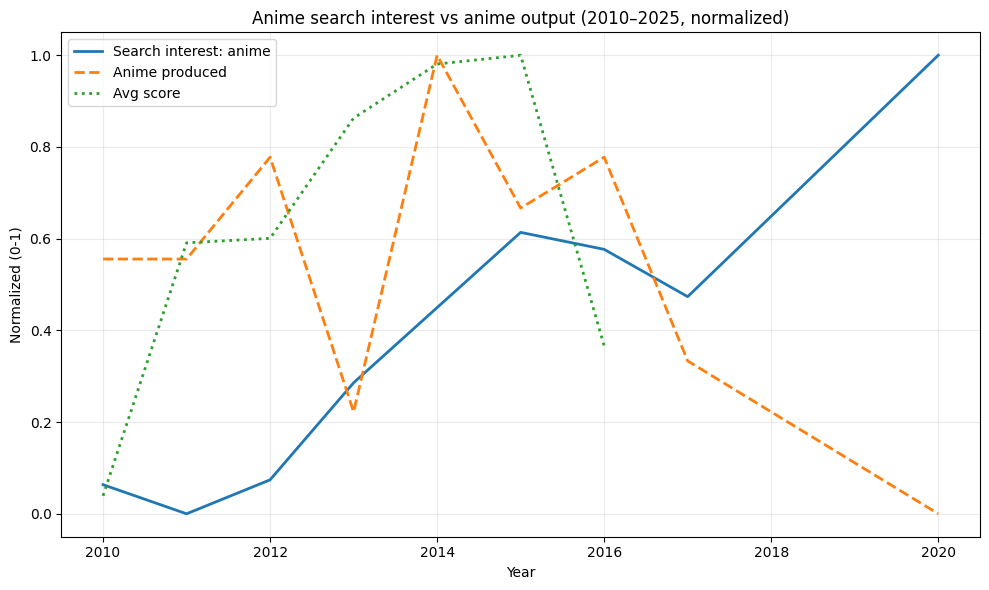


Numeric correlation matrix:
                  year  count_titles  avg_score  median_score  avg_members  \
year          1.000000     -0.449264  -0.194377     -0.248282    -0.384040   
count_titles -0.449264      1.000000   0.464155      0.463685     0.266797   
avg_score    -0.194377      0.464155   1.000000      0.973046     0.316701   
median_score -0.248282      0.463685   0.973046      1.000000     0.432161   
avg_members  -0.384040      0.266797   0.316701      0.432161     1.000000   
anime_trend   0.945387     -0.371750  -0.148388     -0.220571    -0.441441   

              anime_trend  
year             0.945387  
count_titles    -0.371750  
avg_score       -0.148388  
median_score    -0.220571  
avg_members     -0.441441  
anime_trend      1.000000  


In [89]:
# Cell 5 — plotting (normalized)
import matplotlib.pyplot as plt
import numpy as np

merged = pd.read_csv(PROC / "anime_trends_merged.csv")
if merged.shape[0] == 0:
    raise SystemExit("Merged dataset is empty. Check previous cells for issues or overlapping years.")

def norm(s):
    s = pd.to_numeric(s, errors='coerce')
    if s.isna().all(): return s
    if (s.max() - s.min()) == 0: return s
    return (s - s.min())/(s.max()-s.min())

plt.figure(figsize=(10,6))
if 'anime_trend' in merged.columns:
    plt.plot(merged['year'], norm(merged['anime_trend']), label='Search interest: anime', linewidth=2)
if 'count_titles' in merged.columns:
    plt.plot(merged['year'], norm(merged['count_titles']), label='Anime produced', linestyle='--', linewidth=2)
if 'avg_score' in merged.columns:
    plt.plot(merged['year'], norm(merged['avg_score']), label='Avg score', linestyle=':', linewidth=2)

plt.title("Anime search interest vs anime output (2010–2025, normalized)")
plt.xlabel("Year"); plt.ylabel("Normalized (0-1)")
plt.legend(); plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig(OUT / "anime_trend_vs_output.png", dpi=200)
plt.show()

# quick correlation table
print("\nNumeric correlation matrix:")
print(merged.select_dtypes('number').corr())


Fetching: US


/Users/dylandole-vy/projects/anime-globalization-fresh/.venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/var/folders/_s/cs3m2pld1xq5ndtzz9tr3q200000gn/T/ipykernel_93730/4067611349.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dfa = dfw.resample("Y").mean()


Fetching: JP


/Users/dylandole-vy/projects/anime-globalization-fresh/.venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/var/folders/_s/cs3m2pld1xq5ndtzz9tr3q200000gn/T/ipykernel_93730/4067611349.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dfa = dfw.resample("Y").mean()


Fetching: GB


/Users/dylandole-vy/projects/anime-globalization-fresh/.venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/var/folders/_s/cs3m2pld1xq5ndtzz9tr3q200000gn/T/ipykernel_93730/4067611349.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dfa = dfw.resample("Y").mean()


Fetching: KR


/Users/dylandole-vy/projects/anime-globalization-fresh/.venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/var/folders/_s/cs3m2pld1xq5ndtzz9tr3q200000gn/T/ipykernel_93730/4067611349.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dfa = dfw.resample("Y").mean()


Fetching: CA


/Users/dylandole-vy/projects/anime-globalization-fresh/.venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/var/folders/_s/cs3m2pld1xq5ndtzz9tr3q200000gn/T/ipykernel_93730/4067611349.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dfa = dfw.resample("Y").mean()


Saved anime_trends_by_country_yearly.csv rows: 16


,US,JP,GB,KR,CA
date,,,,,
2018,47.833333,40.083333,45.916667,57.333333,52.833333
2019,50.166667,34.250000,45.666667,57.083333,50.666667
2020,73.416667,29.750000,70.916667,51.083333,72.750000
2021,88.666667,30.083333,88.666667,51.833333,88.500000
2022,74.916667,31.333333,76.333333,50.750000,82.583333
2023,66.416667,39.916667,69.000000,58.750000,76.416667
2024,65.750000,48.083333,74.500000,81.000000,77.833333
2025,69.090909,49.272727,77.272727,83.272727,77.545455


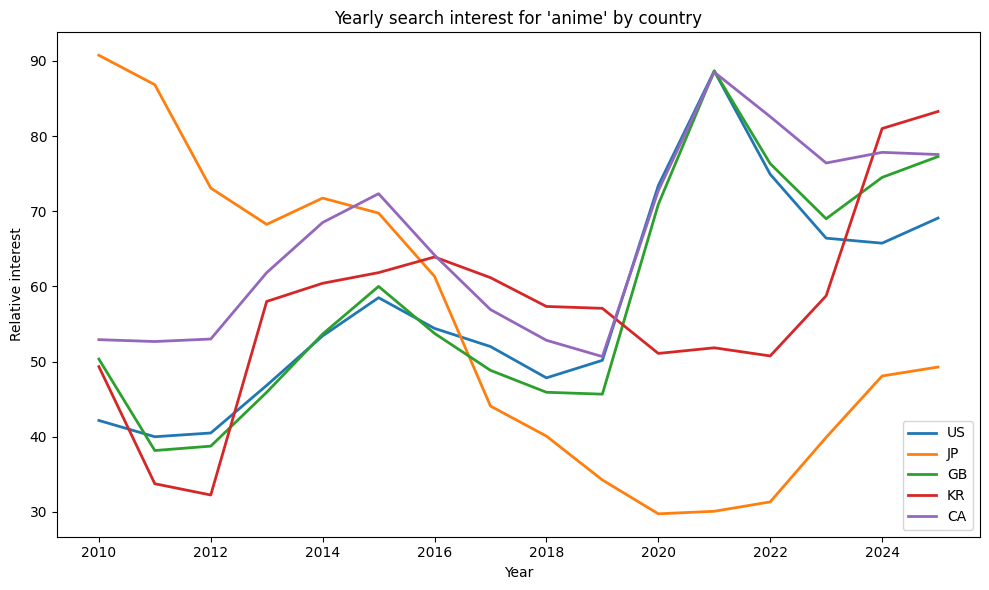

In [90]:
# Cell 6 — regional yearly trends for a few countries (US, JP, GB, KR)
from pytrends.request import TrendReq
import pandas as pd, time

countries = ["US","JP","GB","KR","CA"]  # trim/add as you like; rate-limited
pytrends = TrendReq(hl="en-US", tz=360)
kw = ["anime"]
region_out = {}
for g in countries:
    try:
        print("Fetching:", g)
        pytrends.build_payload(kw, timeframe="2010-01-01 2025-12-31", geo=g)
        dfw = pytrends.interest_over_time().drop(columns=["isPartial"], errors="ignore")
        dfw.index = pd.to_datetime(dfw.index)
        dfa = dfw.resample("Y").mean()
        dfa.index = dfa.index.year
        region_out[g] = dfa[kw[0]]
        time.sleep(1)  # small pause to be polite
    except Exception as e:
        print("Error fetching", g, type(e).__name__, e)
        time.sleep(5)

region_df = pd.DataFrame(region_out)
region_df.to_csv(PROC / "anime_trends_by_country_yearly.csv")
print("Saved anime_trends_by_country_yearly.csv rows:", region_df.shape[0])
display(region_df.tail(8))

# quick plot
region_df.plot(figsize=(10,6), linewidth=2)
plt.title("Yearly search interest for 'anime' by country")
plt.xlabel("Year"); plt.ylabel("Relative interest")
plt.tight_layout()
plt.savefig(OUT / "anime_trends_by_country.png", dpi=200)
plt.show()


In [91]:
# Cell 7 — save summaries and print quick stats
import pandas as pd
from pathlib import Path

merged = pd.read_csv(PROC / "anime_trends_merged.csv")
print("Merged rows:", merged.shape[0])
if merged.shape[0] > 0:
    print("\nTop rows:\n", merged.head().to_string(index=False)[:1000])
    corr = merged.select_dtypes('number').corr()
    print("\nCorrelation matrix:\n", corr.to_string()[:2000])
    (OUT / "README_SUMMARY.txt").write_text(f"Merged rows: {merged.shape[0]}\nColumns: {merged.columns.tolist()}\n\nCorrelation:\n{corr.to_string()}")
    print("\nWrote summary to", OUT / "README_SUMMARY.txt")
else:
    print("Merged is empty; no summary written.")


Merged rows: 9

Top rows:
  year  count_titles  avg_score  median_score  avg_members  anime_trend
 2010             6   5.941667         5.965  1246.500000    39.333333
 2011             6   6.668333         6.955 73456.666667    37.333333
 2012             8   6.681250         6.760  7972.000000    39.666667
 2013             3   7.026667         7.000 15984.666667    46.333333
 2014            10   7.182000         7.065 32923.300000    51.500000

Correlation matrix:
                   year  count_titles  avg_score  median_score  avg_members  anime_trend
year          1.000000     -0.449264  -0.194377     -0.248282    -0.384040     0.945387
count_titles -0.449264      1.000000   0.464155      0.463685     0.266797    -0.371750
avg_score    -0.194377      0.464155   1.000000      0.973046     0.316701    -0.148388
median_score -0.248282      0.463685   0.973046      1.000000     0.432161    -0.220571
avg_members  -0.384040      0.266797   0.316701      0.432161     1.000000    -0.4414